<div style="background-color: black; color: white; padding: 10px;text-align: center;">
  <strong>Date Published:</strong> May 25, 2025 <strong>Author:</strong> Adnan Alaref
</div>

### ✅ Concept Introduction  
**Model calibration** : refers to how well a model’s predicted probabilities reflect the true likelihood of an event. A well-calibrated model predicts with confidence that matches reality — for example, among all predictions with 70% confidence, around 70% should be correct. Poor calibration can mislead decisions, especially in sensitive areas like healthcare or finance.

---

### ⚙️ 4-Step Calibration Workflow

#### 🌟 1. Identify the Problem  
- Evaluate whether your model is miscalibrated using metrics like **Expected Calibration Error (ECE)** or **reliability diagrams**.  
- Warning signs: The model has decent accuracy but unreliable confidence scores (overconfident or underconfident).

#### 🔥 2. Visualize Calibration  
- Plot a **reliability curve** (predicted probabilities vs. actual outcomes).  
- Use tools like `sklearn.calibration_curve` or `CalibrationDisplay` to spot calibration issues.

#### 🎯 3. Apply Calibration Techniques  
- Use methods such as:
  - **Platt Scaling** (logistic regression on logits)
  - **Isotonic Regression** (non-parametric)
  - **Temperature Scaling** (commonly used with neural nets)
- These techniques adjust predicted probabilities without changing predicted classes.

#### 🧠 4. Evaluate Post-Calibration  
- After calibration, re-calculate ECE and visualize the new reliability curve.  
- A well-calibrated model should now show a closer alignment between predicted and actual probabilities.

---



### 📈 Interpreting the Calibration Curve

In a **reliability diagram**, each point compares the model’s **predicted probability** (x-axis) with the **actual accuracy** for that probability bin (y-axis). The **ideal calibration line** is the 45° diagonal — meaning the predicted confidence matches the observed frequency.

Here's how to interpret the position of each point relative to this line:

- **🟢 On the 45° line**:  
  Perfect calibration — the model’s predicted probability equals the true likelihood.

- **🔴 Below the 45° line** (Overconfidence):  
  The model predicts a higher probability than the actual success rate.  
  _Example: predicts 90%, but only 70% are actually correct._

- **🔵 Above the 45° line** (Underconfidence):  
  The model predicts a lower probability than the true success rate.  
  _Example: predicts 50%, but 70% of those predictions are correct._

🚀 **Goal**: After calibration, the curve should move closer to the 45° line — especially in regions where confidence misalignment was large.

💡 **Note:** These values I get it from code of binary classification below to show you how we can __Interpreting the Calibration Curve__.   

| Mean Predicted Probability | Fraction of Positives | Interpretation           |
|----------------------------|------------------------|---------------------------|
| 0.05                       | 0.00                   | Over-confident            |
| 0.15                       | 0.01                   | Over-confident            |
| 0.25                       | 0.07                   | Over-confident            |
| 0.35                       | 0.22                   | Over-confident            |
| 0.46                       | 0.45                   | Slightly Over-confident   |
| 0.56                       | 0.80                   | Under-confident           |
| 0.66                       | 0.86                   | Under-confident           |
| 0.76                       | 0.97                   | Under-confident           |
| 0.86                       | 0.97                   | Under-confident           |
| 0.96                       | 1.00                   | Under-confident           |

# **◍ Step 1: Import Libraries.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import make_classification
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore' ,category=FutureWarning)

# **◍ Step 2: Model Calibration → Binary Classifier.**

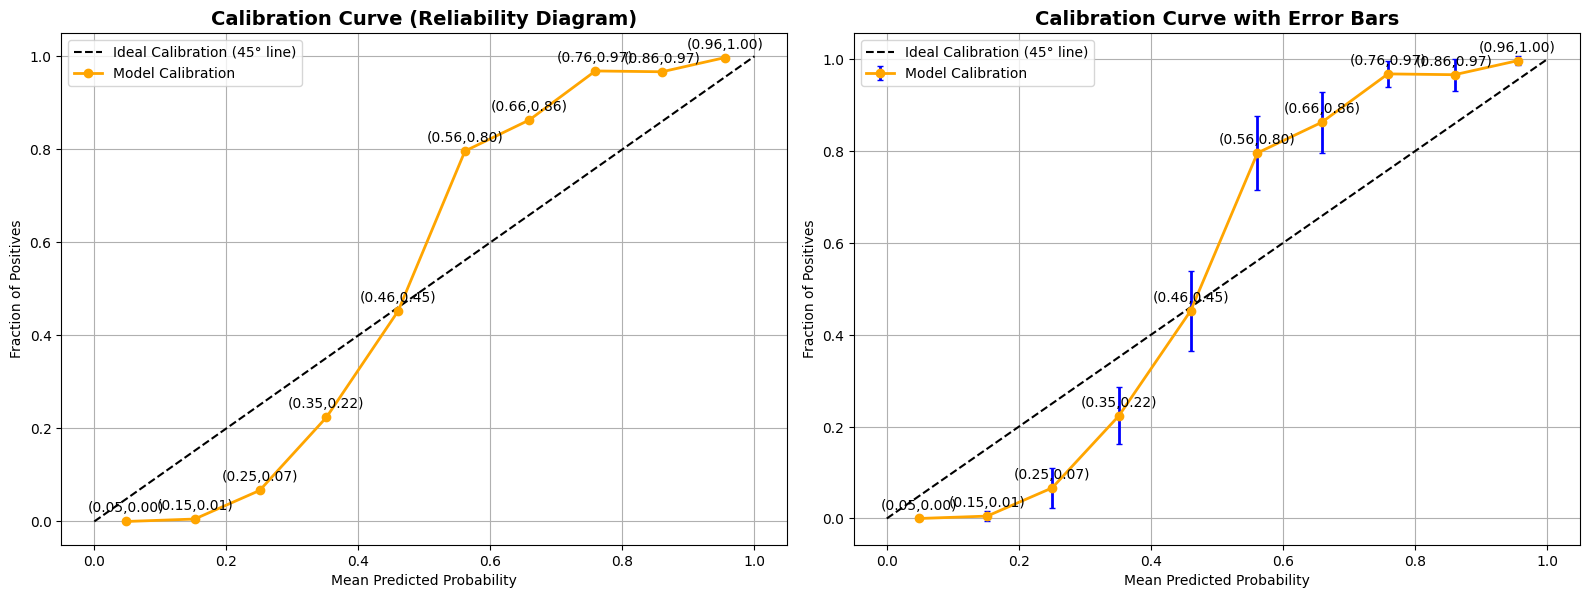


All Points :  [(0.05, 0.0), (0.15, 0.01), (0.25, 0.07), (0.35, 0.22), (0.46, 0.45), (0.56, 0.8), (0.66, 0.86), (0.76, 0.97), (0.86, 0.97), (0.96, 1.0)]


In [2]:
# Create dataset
X, y  = make_classification(n_samples= 5000 ,n_features=20 ,n_informative= 10,random_state=42) #defult 2 class binary classification

# Split dataset in train,test sets
X_train ,X_test ,y_train ,y_test = train_test_split(X, y, test_size=0.3 ,random_state=42)

# Train a RandomForest classifier
model = RandomForestClassifier(n_estimators=100 ,random_state=42)
model.fit(X_train ,y_train)

# Get predictions
y_preds = model.predict_proba(X_test)[:,1] # Focause on positve class

# Clip to avoid edge issues to add error_bar
y_preds = np.clip(y_preds ,0 ,1 -1e-8)

# Calibration curve
prob_fraction_postive ,porb_mean_predicted = calibration_curve(y_test, y_preds, n_bins=10 ,strategy='uniform')

'''
Note:
    Adding error bars to a calibration curve helps visualize the uncertainty (or variance) in the estimated fraction of positives within each bin
    SE = sqrt(p(1-p) / bin_counts)
    bin_ids = np.digitize(x= y_preds ,bins= bins)-1 :
                                            It assigns each value in y_pred to a bin defined by the bins edges
                                            Subtracting 1 (-1) shifts the bins to be 0-indexed
'''

# Bin the data manually to compute the number of samples per bin
bins = np.linspace(0.0,0.1,11)
bin_ids = np.digitize(y_preds ,bins)-1
n_sample_per_bin = np.array([np.sum(bin_ids == i) for i in range(10)])
# n_sample_per_bin = np.bincount(bin_ids, minlength=len(bins) - 1) # make issues not recommended

# Compute standard error for each bin
std_errors = np.sqrt((prob_fraction_postive * (1 - prob_fraction_postive)) / n_sample_per_bin)

# Set up the figure and axes
fig ,ax = plt.subplots(nrows= 1, ncols= 2 ,figsize= (16,6))

# visualize calibration curve
ax[0].plot([0,1], [0,1], linestyle = '--', color = 'black', label = "Ideal Calibration (45° line)")
ax[0].plot(porb_mean_predicted, prob_fraction_postive, marker = 'o', linewidth = 2, color = 'orange', label = 'Model Calibration')

# Annotate each point with coordinates
for x ,y in zip(porb_mean_predicted ,prob_fraction_postive):
  ax[0].text(x, y+0.02, f"({x:.2f},{y:.2f})" ,ha = 'center', fontsize = 10)

ax[0].set_title("Calibration Curve (Reliability Diagram)", fontweight = 'bold', fontsize = 14)
ax[0].set_xlabel("Mean Predicted Probability", fontsize = 10)
ax[0].set_ylabel("Fraction of Positives", fontsize = 10)
ax[0].grid(True)
ax[0].legend()



# visualize calibration curve with error bar
ax[1].plot([0,1], [0,1], linestyle = '--', color = 'black', label = "Ideal Calibration (45° line)")
ax[1].errorbar(porb_mean_predicted, prob_fraction_postive ,yerr=std_errors ,color='orange',
                                  fmt='o-',linewidth=2,capsize=2,ecolor='b', label='Model Calibration')
# Annotate each point with coordinates
for x ,y in zip(porb_mean_predicted ,prob_fraction_postive):
  ax[1].text(x, y+0.02, f"({x:.2f},{y:.2f})" ,ha = 'center', fontsize = 10)

ax[1].set_title("Calibration Curve with Error Bars", fontweight = 'bold', fontsize = 14)
ax[1].set_xlabel("Mean Predicted Probability", fontsize = 10)
ax[1].set_ylabel("Fraction of Positives", fontsize = 10)
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.subplots_adjust(top = 0.95)
plt.savefig("calibration_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# --------------------#
print()
# show all points to interpretation of each point based on its position relative to the ideal 45° calibration line.
calibration_points_base = list(zip(porb_mean_predicted ,prob_fraction_postive))
# Convert to rounded float tuples
cleaned_points_base = [(float(np.round(x,2)),float(np.round(y,2))) for x,y in calibration_points_base]
print("All Points : ",cleaned_points_base)

# **◍ Step 3: Model Calibration → Multiclass Classifier.**

Dateset Shape (X,y):  (5000, 20) (5000,)
Train_Set Shape(X,y) :  (3000, 20) (3000,)  | Test_Set Shape(X,y) :  (1000, 20) (1000,)  | Val_Set Shape(X,y) :  (1000, 20) (1000,) 




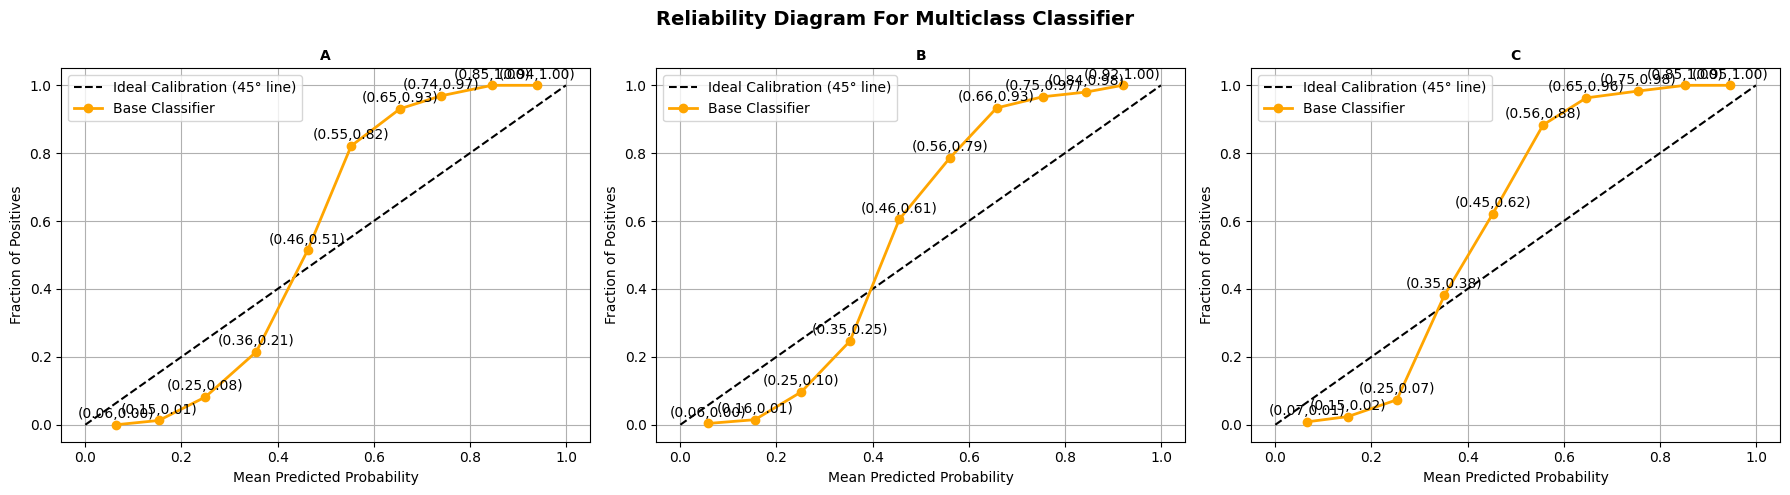

In [3]:
# create dataset with 3 classes = [A, B, C]
X ,y = make_classification(n_samples= 5000, n_features=20, n_informative= 15, n_redundant= 5, n_classes= 3,random_state=42)
print("Dateset Shape (X,y): ",X.shape ,y.shape)

# Split data inot three sets train, val and test
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val ,X_test ,y_val ,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)
print("Train_Set Shape(X,y) : ", X_train.shape ,y_train.shape ," | Test_Set Shape(X,y) : ",X_test.shape
                                                    ,y_test.shape," | Val_Set Shape(X,y) : ",X_val.shape ,y_val.shape,'\n''\n')


# Train a RandomForest classifier
rf_model = RandomForestClassifier(n_estimators=100 ,random_state=42)
rf_model.fit(X_train,y_train)

# Get prediction
y__preds = rf_model.predict_proba(X_test)

# Set up the figure and axes
fig ,axes = plt.subplots(nrows= 1, ncols=3 ,figsize = (18,5))
fig.suptitle("Reliability Diagram For Multiclass Classifier",fontweight ='bold',fontsize = 14)

for idx, (ax, class_name) in enumerate(zip(axes,['A','B','C'])):
  # Compare reliability diagrams
  y_true_prob ,y_predicted_prob = \
                            calibration_curve(y_test == idx, y__preds[:,idx] , n_bins= 10)

  ax.plot([0,1], [0,1], linestyle = '--', color = 'black', label = 'Ideal Calibration (45° line)')
  ax.plot(y_predicted_prob, y_true_prob, linewidth = 2, marker = 'o', color = 'orange', label = 'Base Classifier')

  # Annotate each point with coordinates
  for x,y in zip(y_predicted_prob ,y_true_prob):
    ax.text(x, y+.02, f"({x:.2f},{y:.2f})", ha = 'center', fontsize = 10)

  ax.set_title('%s' % class_name, fontweight = 'bold' ,fontsize = 10)
  ax.set_xlabel("Mean Predicted Probability",fontsize = 10)
  ax.set_ylabel("Fraction of Positives",fontsize = 10)
  ax.grid(True)
  ax.legend()

plt.subplots_adjust(top = 0.85)
plt.tight_layout()
plt.savefig("calibration_plot_Multiclass_Classifier.png", dpi=300, bbox_inches='tight')
plt.show()

# **◍ Step 4: Fix Miscalibration → Multiclass Classifier.**

Classification Report Base Model: 
              precision    recall  f1-score   support

           0       0.83      0.88      0.86       331
           1       0.87      0.91      0.89       348
           2       0.92      0.82      0.86       321

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000

Classification Report Calibrated Model: 
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       331
           1       0.87      0.90      0.88       348
           2       0.90      0.85      0.87       321

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



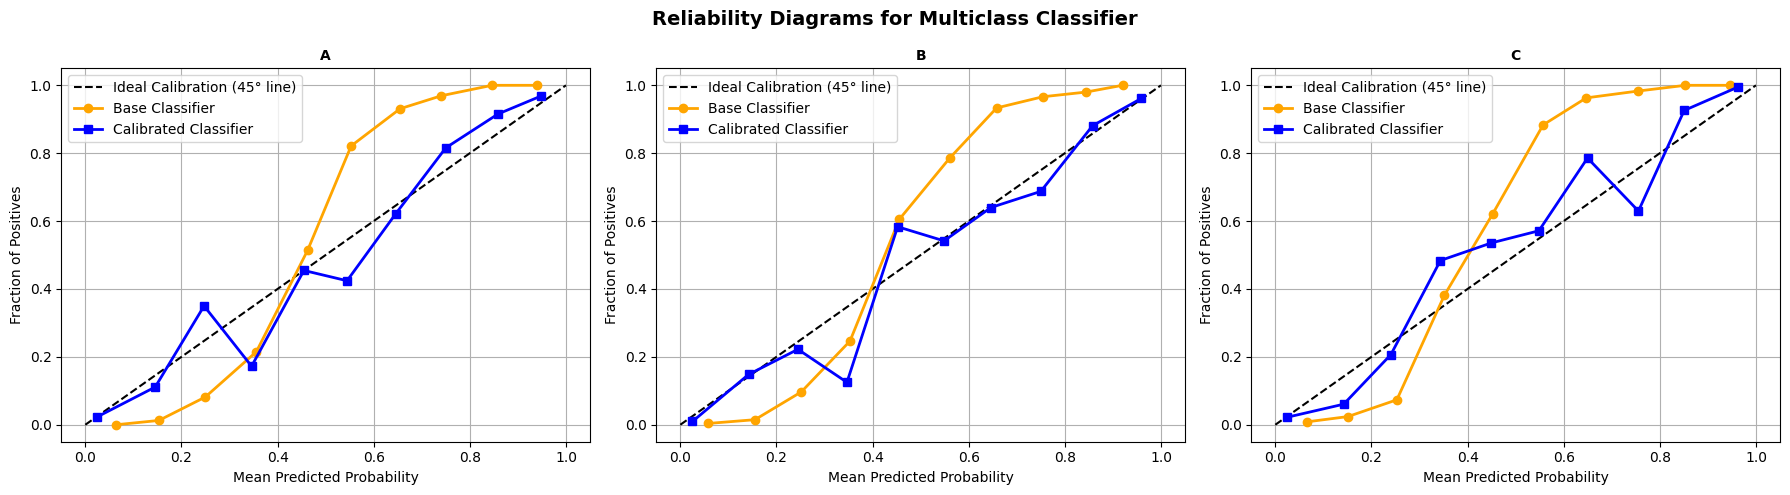

In [4]:
# Generate dataset
X ,y = make_classification(n_samples= 5000, n_features=20, n_informative= 15, n_redundant= 5, n_classes= 3,random_state=42)


# Split data inot three sets train, val and test
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val ,X_test ,y_val ,y_test = train_test_split(X_val_test ,y_val_test ,test_size=0.5 ,random_state=42)

# Train a RandomForest classifier
clf = RandomForestClassifier(n_estimators=100 ,random_state=42)
clf.fit(X_train,y_train)

# Make predictions on clf model
y_pred = clf.predict(X_test)
print("Classification Report Base Model: ")
print(classification_report(y_test ,y_pred))

# Calibrate the classifier
calibrated_clf = CalibratedClassifierCV(clf ,method='sigmoid' ,cv='prefit')
calibrated_clf.fit(X_val ,y_val) # Must train calibrated model on new data set (val set)

# Make predictions on calibrated_clf model
y_pred_calibrated = calibrated_clf.predict(X_test)
print("Classification Report Calibrated Model: ")
print(classification_report(y_test ,y_pred_calibrated))

# Predict probabilities on the test set using both classifiers
prob_pos_base = clf.predict_proba(X_test)
prob_pos_calibrated = calibrated_clf.predict_proba(X_test)

# Set up the figure and axes
fig ,axes = plt.subplots(nrows=1,ncols=3,figsize = (18,5))
fig.suptitle('Reliability Diagrams for Multiclass Classifier', fontweight ='bold',fontsize = 14)

for i, (ax, class_name) in enumerate(zip(axes, ["A" ,"B","C"])):
  # Compare reliability diagrams
  fraction_of_positives_base, mean_predicted_value_base = \
                                      calibration_curve(y_test==i, prob_pos_base[:,i], n_bins=10)
  fraction_of_positives_calibrated, mean_predicted_value_calibrated = \
                                      calibration_curve(y_test==i, prob_pos_calibrated[:,i], n_bins=10)

  ax.plot([0,1], [0,1], linestyle = '--', color = 'black', label = 'Ideal Calibration (45° line)')
  ax.plot(mean_predicted_value_base, fraction_of_positives_base, linewidth = 2, marker = 'o', color = 'orange', label = 'Base Classifier')
  ax.plot(mean_predicted_value_calibrated ,fraction_of_positives_calibrated, linewidth = 2, marker = 's', color = 'b', label = 'Calibrated Classifier')

  ax.set_title('%s' % class_name, fontweight = 'bold' ,fontsize = 10)
  ax.set_xlabel("Mean Predicted Probability",fontsize = 10)
  ax.set_ylabel("Fraction of Positives",fontsize = 10)
  ax.grid(True)
  ax.legend()

plt.subplots_adjust(top = 0.85)
plt.tight_layout()
plt.savefig("Compare_reliability_diagrams.png", dpi=300, bbox_inches='tight')
plt.show()

### 📊 Line-by-Line Insights from the Reliability Diagrams

---

#### 🟠 Base Classifier (Orange Line)

- In all three panels (A, B, and C), the base classifier is **overconfident**.
- For example, in **Panel A**, at a predicted probability of **0.8**, the actual fraction of positives is only around **0.6**.
- In **Panel B**, even worse — the model predicts **90%** confidence but achieves **~75%** actual accuracy.
- This means the model is **too sure** about its predictions, which can be risky when using probability thresholds for decision-making.

---

#### 🔵 Calibrated Classifier (Blue Line)

- After applying calibration, the classifier's predicted probabilities **better match the observed outcomes**.
- In **Panel A**, calibration shifts the 0.8 confidence point **upwards** to match closely with the 0.8 actual accuracy — a big improvement.
- In **Panel B**, the blue curve is now much **closer to the 45° line**, especially from **0.4 to 0.8**, where the base model failed.
- In **Panel C**, although calibration helps in the low-probability range (e.g., at 0.3, predicted ≈ actual), there's still some **zig-zag noise**, showing calibration isn't perfect.

---

#### ⚫ Ideal Calibration Line (Dashed Line)

- This line represents **perfect calibration** — every predicted probability aligns with the actual outcome.
- Every point on the 45° line means:  
  _“When the model predicts 60%, it's actually correct 60% of the time.”_
- It acts as a **benchmark** — both base and calibrated curves are evaluated by how close they come to this ideal.

---

🎯 **Goal:** Calibration reduces the gap between predicted confidence and true likelihood, making models more trustworthy in real-world applications.

📝 **Note:** Even highly accurate models may be poorly calibrated — always check calibration before using probabilities in decision systems.


### ✅ Conclusion  
Model calibration aligns predicted probabilities with actual outcomes, improving trust in model decisions.  
Even simple post-training calibration methods can significantly reduce overconfidence and enhance reliability.


<a id="Import"></a>
<p style="background-color: #000000; font-family: 'Verdana', sans-serif; color: #FFFFFF; font-size: 160%; text-align: center; border-radius: 25px; padding: 12px 20px; margin-top: 20px; border: 2px solid transparent; background-image: linear-gradient(black, black), linear-gradient(45deg, #FF00FF, #00FFFF, #FFFF00, #FF4500); background-origin: border-box; background-clip: content-box, border-box; box-shadow: 0px 4px 20px rgba(255, 105, 180, 0.8);">
   Thanks & Upvote ❤️</p>